Dans ce notebook on va réaliser nos expérimentations.

À partir d'un VGG que l'on fine-tune pour 15scene, on va tester les performances d'un générator entraîner sur ImageNet.

In [0]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import numpy as np
from PIL import Image

import time
import os
import warnings
warnings.simplefilter("ignore", UserWarning)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Generateur

### Architecture de l'encodeur décodeur pour ImageNet.



In [0]:
class Imagenet_Encoder(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1_1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(16)
        )
        self.conv1_2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv2_1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64)
        )
        self.conv2_2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv3_1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128)
        )
        self.conv3_2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv4_1 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32)
        )
        self.conv4_2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.MaxPool2d(kernel_size=2)
        )

    def forward(self, x):
        x = self.conv1_1(x)
        x = self.conv1_2(x)
        x = self.conv2_1(x)
        x = self.conv2_2(x)
        x = self.conv3_1(x)
        x = self.conv3_2(x)
        x = self.conv4_1(x)
        x = self.conv4_2(x)

        return x


class Imagenet_Decoder(nn.Module):

    def __init__(self):
        super().__init__()

        self.deconv1_1 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32)
        )
        self.deconv1_2 = nn.Sequential(
            nn.ConvTranspose2d(32, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64)
        )
        self.deconv2_1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128)
        )
        self.deconv2_2 = nn.Sequential(
            nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128)
        )
        self.deconv3_1 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128)
        )
        self.deconv3_2 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64)
        )
        self.deconv4_1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32)
        )
        self.deconv4_2 = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(16)
        )
        self.fcn = nn.Conv2d(16, 3, kernel_size=1)

    def forward(self, x):
        n = len(x)
        x = x.view(n, 8, 14, 14)

        y = self.deconv1_1(x)
        y = self.deconv1_2(y)
        y = self.deconv2_1(y)
        y = self.deconv2_2(y)
        y = self.deconv3_1(y)
        y = self.deconv3_2(y)
        y = self.deconv4_1(y)
        y = self.deconv4_2(y)
        y = self.fcn(y)

        return torch.tanh(y)

### Créé notre générateur.

On va utiliser les poids d'un générateur déjà entraîné.

(Les poids sont présent dans le github)

In [0]:
weight = torch.load(os.path.join("Imagenet_Generator_untarget.pytorch"), map_location=device)

encoder_weight = {}
decoder_weight = {}
for key, val in weight.items():
    if key.startswith('0.'):
        encoder_weight[key[2:]] = val
    elif key.startswith('1.'):
        decoder_weight[key[2:]] = val

encoder = Imagenet_Encoder()
decoder = Imagenet_Decoder()
encoder.load_state_dict(encoder_weight)
decoder.load_state_dict(decoder_weight)
encoder.to(device)
decoder.to(device)


batch_size = 1

## 15scene

### Chargement des données

In [0]:
!wget https://webia.lip6.fr/~douillard/rdfia/tp8.zip
!unzip tp8.zip 

--2020-02-10 19:04:22--  https://webia.lip6.fr/~douillard/rdfia/tp8.zip
Resolving webia.lip6.fr (webia.lip6.fr)... 132.227.201.33
Connecting to webia.lip6.fr (webia.lip6.fr)|132.227.201.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 86574454 (83M) [application/zip]
Saving to: ‘tp8.zip.2’

tp8.zip.2           100%[===================>]  82.56M  21.2MB/s    in 3.9s    

2020-02-10 19:04:27 (21.2 MB/s) - ‘tp8.zip.2’ saved [86574454/86574454]

Archive:  tp8.zip
replace tp8/transfer.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [0]:
def get_dataset(batch_size, path, mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]):

    # Cette fonction permet de recopier 3 fois une image qui
    # ne serait que sur 1 channel (donc image niveau de gris)
    # pour la "transformer" en image RGB. Utilisez la avec
    # transform.Lambda
    def duplicateChannel(img):
        img = img.convert('L')
        np_img = np.array(img, dtype=np.uint8)
        np_img = np.dstack([np_img, np_img, np_img])
        img = Image.fromarray(np_img, 'RGB')
        return img

    transform=transforms.Compose([
            transforms.Resize(256),                   
            transforms.CenterCrop(224), 
            transforms.Lambda(duplicateChannel),
            transforms.ToTensor(),
            transforms.Normalize(mean, std, inplace=False)     
        ])

    train_loader = torch.utils.data.DataLoader(datasets.ImageFolder(path+'/train', transform=transform),
                        batch_size=batch_size, shuffle=False)
    val_loader = torch.utils.data.DataLoader(datasets.ImageFolder(path+'/test', transform=transform),
                        batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

train_loader, test_loader = get_dataset(batch_size, "/content/tp8/15SceneData")

### Chargement du VGG entrainer sur 15scene.



In [0]:
class VGG16relu7(torch.nn.Module):
    def __init__(self,vgg16):
        super(VGG16relu7,self).__init__()
        self.features = torch.nn.Sequential(*list(vgg16.features.children()))
        self.classifier = torch.nn.Sequential(*list(vgg16.classifier.children())[:-2])


    def forward(self,x):
        x = self.features(x)
        x = x.view(x.size(0),-1)
        x = self.classifier(x)
        return x 


class MLP_15Scene(torch.nn.Module):
    def __init__(self, mlp):
        super(MLP_15Scene,self).__init__()
        self.classifier = torch.nn.Sequential(*list(mlp.classifier.children()))

    def forward(self,x):
        return self.classifier(x)


In [0]:
vgg16 = torchvision.models.vgg16(pretrained=True)

#features_extract = VGG16relu7(vgg16)
#features_extract.to(device)
#model = MLP_15Scene()
model = torch.load('15Scene_classifier.pt')

vgg_15scene = nn.Sequential(
    VGG16relu7(vgg16),
    MLP_15Scene(model)
)

vgg_15scene.to(device)

print("vgg 15scene loader")

vgg 15scene loader


## Teste sur 15scenes

In [0]:
class Function(nn.Module):

    def __init__(self, model, batch_size=256, margin=0, nlabels=10, target=False):
        super(Function, self).__init__()
        self.model = model
        self.margin = margin
        self.target = target
        self.batch_size = batch_size
        self.current_counts = 0
        self.counts = []
        self.nlabels = nlabels

    def _loss(self, logits, label):
        if not self.target:
            if label == 0:
                logits_cat = logits[:,(label+1):]
            elif label == logits.size()[1] - 1:
                logits_cat = logits[:, :label]
            else:
                logits_cat = torch.cat((logits[:, :label],logits[:,(label+1):]), dim=1)
            diff = logits[:,label] - torch.max(logits_cat, dim=1)[0]
            margin = torch.nn.functional.relu(diff + self.margin, True) - self.margin
        else:
            diff = torch.max(torch.cat((logits[:, :label],logits[:,(label+1):]), dim=1), dim=1)[0] - logits[:, label]
            margin = torch.nn.functional.relu(diff + self.margin, True) - self.margin
        return margin

    def forward(self, images, label):
        if len(images.size())==3:
            images = images.unsqueeze(0)
        
        n = len(images)
        device = images.device
        k = 0
        loss = torch.zeros(n, dtype=torch.float32, device=device)
        logits = torch.zeros((n, self.nlabels), dtype=torch.float32, device=device)

        while k < n:
            start = k
            end = min(k + self.batch_size, n)
            logits[start:end] = self.model(images[start:end])
            tmp = self._loss(logits, label)
            #loss[start:end] = self._loss(logits, label)
            k = end
        self.current_counts += n

        return logits, loss

    def new_counter(self):
        self.counts.append(self.current_counts)
        self.current_counts = 0

    def get_average(self, iter=50000):
        counts = np.array(self.counts)
        return np.mean(counts[counts<iter])
    

In [0]:
def EmbedBA(function, encoder, decoder, image, label, config, latent=None):
    device = image.device

    if latent is None:
        latent = encoder(image.unsqueeze(0)).squeeze().view(-1)
    momentum = torch.zeros_like(latent)
    dimension = len(latent)
    noise = torch.empty((dimension, config['sample_size']), device=device)
    origin_image = image.clone()
    last_loss = []
    lr = config['lr']
    for iter in range(config['num_iters']+1):

        perturbation = torch.clamp(decoder(latent.unsqueeze(0)).squeeze(0)*config['epsilon'], -config['epsilon'], config['epsilon'])
        logit, loss = function(torch.clamp(image+perturbation, 0, 1), label)
        
        success = torch.argmax(logit, dim=1) !=label
        
        last_loss.append(loss.item())

        if function.current_counts > 500:
            break
        
        if bool(success.item()):
            return True, torch.clamp(image+perturbation, 0, 1), perturbation

        nn.init.normal_(noise)
        noise[:, config['sample_size']//2:] = -noise[:, :config['sample_size']//2]
        latents = latent.repeat(config['sample_size'], 1) + noise.transpose(0, 1)*config['sigma']
        perturbations = torch.clamp(decoder(latents)*config['epsilon'], -config['epsilon'], config['epsilon'])
        
        
        t=image.expand_as(perturbations)
        
        _, losses = function(torch.clamp(image.expand_as(perturbations) + perturbations, 0, 1), label)

        grad = torch.mean(losses.expand_as(noise) * noise, dim=1)

        if iter % config['log_interval'] == 0 and config['print_log']:
            print("iteration: {} loss: {}, l2_deviation {}".format(iter, float(loss.item()), float(torch.norm(perturbation))))

        momentum = config['momentum'] * momentum + (1-config['momentum'])*grad

        latent = latent - lr * momentum

        last_loss = last_loss[-config['plateau_length']:]
        if (last_loss[-1] > last_loss[0]+config['plateau_overhead'] or last_loss[-1] > last_loss[0] and last_loss[-1]<0.6) and len(last_loss) == config['plateau_length']:
            if lr > config['lr_min']:
                lr = max(lr / config['lr_decay'], config['lr_min'])
            last_loss = []

    return False, origin_image, None


In [0]:
margin = 200.0
config = {'epsilon': 0.03125, 'sample_size': 20, 'plateau_length': 20, 'plateau_overhead': 0.3, "num_iters": 2500,
  "sigma": 1.0, "lr": 5.0, "lr_min": 0.1, "lr_decay": 2.0, "momentum": 0.0, 'target': False, 'log_interval': 1000, 'print_log': False}

F = Function(vgg_15scene, batch_size, margin, 15, False)
resultat = []
resultat_pos = []
count_success = 0
count_total = 0
moy_sec = 0

for i, (images, labels) in enumerate(test_loader):
    start_time = time.time()

    images = images.to(device)
    labels = labels.to(device)
    logits = vgg_15scene(images)
    correct = (torch.sum(torch.argmax(logits, 1) == labels).item()) == len(images)
    if correct:
        torch.cuda.empty_cache()
        with torch.no_grad():
            success, adv, _ = EmbedBA(F, encoder, decoder, images[0], labels, config)

        count_success += int(success)
        count_total += int(correct)
        print("image: {} eval_count: {} success: {} average_count: {} success_rate: {}".format(i, F.current_counts, success, F.get_average(), float(count_success) / float(count_total)))
        resultat.append(F.current_counts)
        if success:
            resultat_pos.append(F.current_counts)
        F.new_counter()

    
    end_time = time.time()
    moy_sec += round(end_time - start_time, 4)
    if count_total % 10 == 0:
        print("\nTemps moyen d'une epoch =", round(moy_sec/i, 3), "| Temps restant =", round((moy_sec/i*(len(test_loader) - i)) / 60, 2), '\n')



/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


image: 0 eval_count: 505 success: False average_count: nan success_rate: 0.0
image: 1 eval_count: 505 success: False average_count: 505.0 success_rate: 0.0
image: 2 eval_count: 505 success: False average_count: 505.0 success_rate: 0.0
image: 4 eval_count: 505 success: False average_count: 505.0 success_rate: 0.0
image: 5 eval_count: 505 success: False average_count: 505.0 success_rate: 0.0
image: 6 eval_count: 505 success: False average_count: 505.0 success_rate: 0.0
image: 10 eval_count: 22 success: True average_count: 505.0 success_rate: 0.14285714285714285
image: 11 eval_count: 505 success: False average_count: 436.0 success_rate: 0.125
image: 12 eval_count: 505 success: False average_count: 444.625 success_rate: 0.1111111111111111
image: 13 eval_count: 505 success: False average_count: 451.3333333333333 success_rate: 0.1

Temps moyen d'une epoch = 4.138 | Temps restant = 204.98 

image: 14 eval_count: 1 success: True average_count: 456.7 success_rate: 0.18181818181818182
image: 15 

In [0]:
print(len(resultat_pos)/len(resultat))
print(sum(resultat) / len(resultat))
print(sum(resultat_pos) / len(resultat_pos))

0.7151561309977151
164.76961157654227
29.257188498402556


Generation d'image adversaire.

In [0]:
F = Function(vgg_15scene, batch_size, margin, 15, False)
images_adv = []
for i, (images, labels) in enumerate(test_loader):

    images = images.to(device)
    labels = labels.to(device)
    logits = vgg_15scene(images)
    correct = (torch.sum(torch.argmax(logits, 1) == labels).item()) == len(images)
    if correct:
        torch.cuda.empty_cache()
        with torch.no_grad():
            success, adv, bruit = EmbedBA(F, encoder, decoder, images[0], labels, config)

        if success:
            images_adv.append((images, adv, bruit))
            
            if len(images_adv) > 10:
                break

        F.new_counter()

    

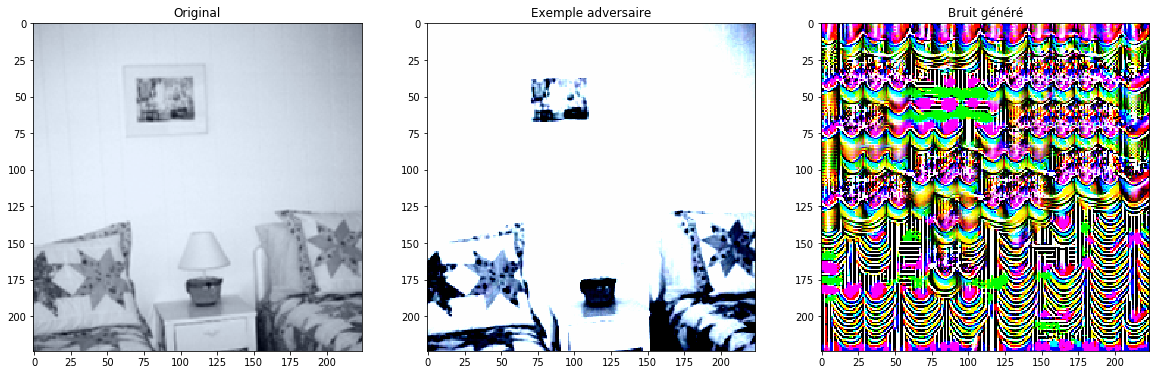

In [0]:
i=3

f = plt.figure(figsize=(20,20))
f.add_subplot(1,3, 1)
plt.imshow(np.transpose(torchvision.utils.make_grid(images_adv[i][0], padding=1, normalize=True, nrow=1).cpu(), (1,2,0)))
plt.title("Original")
f.add_subplot(1,3, 2)
plt.imshow(np.transpose(torchvision.utils.make_grid(images_adv[i][1], padding=1, normalize=True, nrow=1).cpu(), (1,2,0)))
plt.title("Exemple adversaire")
f.add_subplot(1,3, 3)
plt.imshow(np.transpose(torchvision.utils.make_grid(images_adv[i][2], padding=1, normalize=True, nrow=1).cpu(), (1,2,0)))
plt.title("Bruit généré")
plt.show(block=True)
